In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hyunkic_twitter_depression_dataset_path = kagglehub.dataset_download('hyunkic/twitter-depression-dataset')

print('Data source import complete.')


In [ ]:
!pip install kaggle --quiet

import os
import zipfile
from google.colab import files

# Upload kaggle.json file (you need to download this from your Kaggle account)
print("Upload kaggle.json file downloaded from Kaggle API...")
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key

# Download the dataset to the content/ folder
dataset_name = "hyunkic/twitter-depression-dataset"
download_path = "/content"
print(f"Downloading dataset: {dataset_name} ...")
!kaggle datasets download -d {dataset_name} -p {download_path} --quiet

<ipython-input-4-520b93c1da0f>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['tweet'].fillna('', inplace=True)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 199.5/199.5MB downloaded


<ipython-input-4-520b93c1da0f>:53: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embedding_matrix[i] = gt_vec.word_vec(word)


Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.7668 - loss: 0.4697 - val_accuracy: 0.8398 - val_loss: 0.3528
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.8614 - loss: 0.3128 - val_accuracy: 0.8430 - val_loss: 0.3405
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.8621 - loss: 0.3042 - val_accuracy: 0.8597 - val_loss: 0.3199
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.8750 - loss: 0.2868 - val_accuracy: 0.8713 - val_loss: 0.3113
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8868 - loss: 0.2681 - val_accuracy: 0.8719 - val_loss: 0.3099
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.8896 - loss: 0.2450 - val_accuracy: 0.8764 - val_loss: 0.3078
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9078 - loss: 0.2342 - val_accuracy: 0.8636 - val_loss: 0.3386
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9050 - loss: 0.2260 

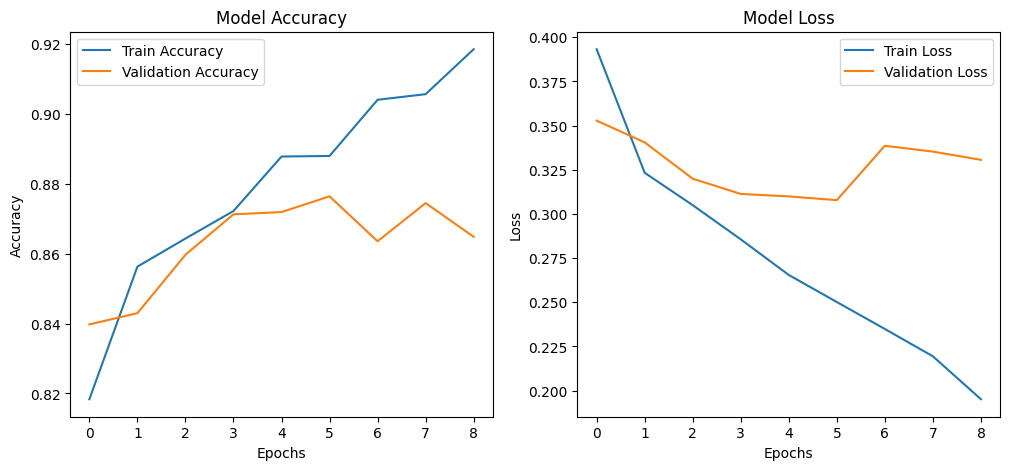

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       922
           1       0.84      0.82      0.83       632

    accuracy                           0.86      1554
   macro avg       0.86      0.86      0.86      1554
weighted avg       0.86      0.86      0.86      1554



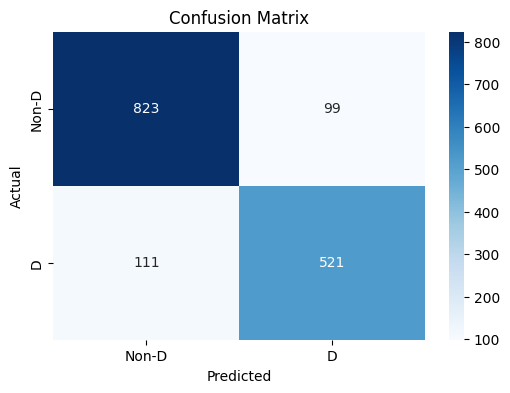

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader

# Load datasets
d_tweets = pd.read_csv('clean_d_tweets.csv')
non_d_tweets = pd.read_csv('clean_non_d_tweets.csv')

# Combine datasets and label
d_tweets['label'] = 1
non_d_tweets['label'] = 0
data = pd.concat([d_tweets, non_d_tweets])

# Handle missing values
data['tweet'].fillna('', inplace=True)

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

data['tweet'] = data['tweet'].apply(preprocess_text)

# Load GloVe embeddings
gt_vec = gensim.downloader.load('glove-twitter-50')

# Create embedding matrix
vocab_size = 5000
embedding_dim = 50
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(data['tweet'])
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in gt_vec.key_to_index:
        embedding_matrix[i] = gt_vec.word_vec(word)

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(data['tweet'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded, data['label'], test_size=0.2, random_state=42)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-D', 'D'], yticklabels=['Non-D', 'D'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
# ✅ Custom Input Prediction Function
def custom_input():
    print("\n=========================")
    print(" 💡 Enter a Tweet to Predict Depression:")
    user_text = input("👉 Enter your text here: ")

    # Preprocess the text
    processed_text = preprocess_text(user_text)
    seq = tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=100, padding='post')

    # Predict Depression
    prediction = model.predict(padded_seq)[0][0]
    if prediction > 0.5:
        print(f"\n😞 Prediction: **Depressed** with {round(prediction*100, 2)}% probability.")
    else:
        print(f"\n😊 Prediction: **Not Depressed** with {round((1-prediction)*100, 2)}% probability.")

# Run Custom Input Function
custom_input()



 💡 Enter a Tweet to Predict Depression:
👉 Enter your text here: i am very bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

😞 Prediction: **Depressed** with 72.28% probability.
